<a href="https://colab.research.google.com/github/vroomgit/FraudDetectionFNN/blob/main/Fraud_Detection_Feedforward_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparison of Linear Neural Network and XGBoost on a simulated financial dataset.

This dataset poses a binary classification problem with some of the transactions that are fraud and the others that are legitimate. This dataset has high degree of class imbalance.
Link to dataset: https://www.kaggle.com/datasets/ealaxi/paysim1

# Model 1: Feedforward Neural Network

## Environment prep and data unzipping (This section needed for Google Colab)

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Aug 10 14:02:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Loading and Preparing Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import matplotlib.pyplot as plt
from collections import Counter
import time
from time import sleep
!pip install pycm
import pycm
import prettytable
import sys
from imblearn.over_sampling import SMOTE
!{sys.executable}  -m pip -q -q install matplotlib;
!{sys.executable}  -m pip -q -q install seaborn;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.4/599.4 kB 9.8 MB/s eta 0:00:00


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
df = pd.read_csv('/content/drive/MyDrive/Projects/Finance Dataset Kaggle/FFDS.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [7]:
# For the fraud cases, are all nameOrig (origin ID) different? If yes, then this column can be dropped.
len(pd.unique(df.nameOrig[df.isFraud==1])) == len(df[df.isFraud==1])


True

In [8]:
# For the fraud cases, are all nameDest (destination ID) different? If yes, then this column can be dropped.
len(pd.unique(df.nameDest[df.isFraud==1]))

8169

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [10]:
# Percentage of labels = 1
(len(df)-len(df[df['isFraud']==1]))/len(df)

0.9987091795518198

In [11]:
# dropping column 'isFlaggedFraud' and nameOrig
df.drop(columns=['isFlaggedFraud'],inplace=True)
df.drop(columns=['nameOrig'],inplace=True)

In [12]:
# Number of nulls in dataset
for col in df.columns:
    print(col, df[col].isnull().sum())

step 0
type 0
amount 0
oldbalanceOrg 0
newbalanceOrig 0
nameDest 0
oldbalanceDest 0
newbalanceDest 0
isFraud 0


In order to be fed into a neural network, the four 'object' type columns will be converted to embeddings. Choosing columns that will be encoded and calculating embedding sizes.



In [13]:
# Changing datatypes of 'object' types to 'category'

df["step"] = df["step"].astype("category")
df["type"] = df["type"].astype("category")
#df["nameOrig"] = df["nameOrig"].astype("category")
df["nameDest"] = df["nameDest"].astype("category")

In [14]:
# Defining labels
Y = df['isFraud']
df.drop(columns=['isFraud'],inplace=True)
print(len(df),len(Y))

6362620 6362620


In [15]:
# calculating number of categories in 'category' type columns.
embCol_dict = {}
for n,c in df.items():
  if str(df.dtypes[c.name]) == "category":
    if len(c.cat.categories) > 2:
      embCol_dict[c.name] = len(c.cat.categories)
embCol_dict

{'step': 743, 'type': 5, 'nameDest': 2722362}

Reference https://jovian.ai/aakanksha-ns/shelter-outcome

Below code calculates the size of embeddings based on number of categories in each column. The output size is min(50,(category size+1)/2). In case of step, nameOrig and nameDest, embeddings help in reducing categories to embeddings of length 50

In [16]:
# computing embedding sizes
embedding_sizes = [(n_categories, min(16, (n_categories+1)//2)) for _,n_categories in embCol_dict.items()]
embedding_sizes

[(743, 16), (5, 3), (2722362, 16)]

In [17]:
embCol_list = embCol_dict.keys()
len(embCol_list)

3

Encoding text categories in 'category' columns to integer codes using Sklearn's LabelEncoder

In [18]:
for col in df.columns:
  if (df.dtypes[col]) == "category":
    df[col] = LabelEncoder().fit_transform(df[col])

As 99.87% of data points are legitimate trasactions, we need to oversample the fraud transactions (label=1). Using SMOTE to oversample the minority class:

In [19]:
sm = SMOTE(random_state = 13)
df, Y = sm.fit_resample(df, Y)

In [20]:
len(Y)

12708814

Portioning 70% data for training and 15% each for validation and testing.

In [21]:
np.random.seed(13)
X_train, X_val_test, y_train, y_val_test = train_test_split(df, Y, test_size=0.30)
X_train.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
4786200,344,0,224871.120000,4.522400e+04,270095.12,271472,6.228510e+06,6.003639e+06
5780617,399,0,22469.230000,1.429763e+06,1452232.69,5754,2.992955e+05,2.768263e+05
2664855,209,1,60745.780000,0.000000e+00,0.00,264164,1.428495e+06,1.489241e+06
7451605,84,1,35375.733969,3.537573e+04,0.00,508214,2.086395e+06,2.121771e+06
3994173,297,3,9725.520000,0.000000e+00,0.00,1524271,0.000000e+00,0.000000e+00


In [22]:
np.random.seed(13)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.50)

In [23]:
# reset indexes to avoid errors in dataloader class
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)



In [24]:
print(len(X_train),len(y_train),len(X_val),len(y_val),len(X_test),len(y_test))

8896169 8896169 1906322 1906322 1906323 1906323


Data after encoding 'category' columns.

In [25]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
0,0,3,9839.64,170136.0,160296.36,1662094,0.0,0.0
1,0,3,1864.28,21249.0,19384.72,1733924,0.0,0.0
2,0,4,181.00,181.0,0.00,439685,0.0,0.0
3,0,1,181.00,181.0,0.00,391696,21182.0,0.0
4,0,3,11668.14,41554.0,29885.86,828919,0.0,0.0


Defining the Dataset class.

In [ ]:
class FraudData(Dataset):
    def __init__(self, df, y, embCol_list):

        self.X1 = df.loc[:,embCol_list].copy().values.astype(np.int64)
        self.X2 = df.drop(columns = embCol_list).copy().values.astype(np.float32)
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X1[idx], self.X2[idx], self.y[idx]

Creating Dataset objects for Train/Validation/Test data

In [ ]:
train_data = FraudData(X_train, y_train, embCol_list)
valid_data = FraudData(X_val, y_val, embCol_list)
test_data = FraudData(X_test, y_test, embCol_list)

In [ ]:
print(len(train_data),len(valid_data),len(test_data))

8896169 1906322 1906323


Defining Hyperparameters and Dataloader objects

In [ ]:
# Hyperparameters and creating train and validation loader variables

batch_size = 4096
lr = 0.0001
w_decay = 0.00001



trainloader = DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=0)


validloader = DataLoader(valid_data, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

## Building Feedforward Neural Network.



In [ ]:
class FraudNet(nn.Module):
    def __init__(self, embedding_sizes, n_cont):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(categories, size) for categories,size in embedding_sizes])
        n_emb = sum(e.embedding_dim for e in self.embeddings)
        self.n_emb, self.n_cont = n_emb, n_cont
        self.lin1 = nn.Linear(self.n_emb + self.n_cont, 256)
        self.lin2 = nn.Linear(256, 512)
        self.lin25 = nn.Linear(512, 256)
        self.lin3 = nn.Linear(256, 2)
        self.bn1 = nn.BatchNorm1d(self.n_cont)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(512)
        self.embedding_drop = nn.Dropout(0.6)
        self.drops = nn.Dropout(0.3)


    def forward(self, x_cat, x_cont):
        x = [e(x_cat[:,i]) for i,e in enumerate(self.embeddings)]
        x = torch.cat(x, 1)
        x = self.embedding_drop(x)
        x2 = self.bn1(x_cont)
        x = torch.cat([x, x2], 1)
        x = F.relu(self.lin1(x))
        x = self.drops(x)
        x = self.bn2(x)
        x = F.relu(self.lin2(x))
        x = self.drops(x)
        x = self.bn3(x)
        x = F.relu(self.lin25(x))
        x = self.drops(x)
        x = self.bn2(x)
        x = self.lin3(x)
        return x

n_cont variable contains number of non-encoded columns

In [ ]:
n_cont = len(df.columns) - len(embCol_list)

In [ ]:
net = FraudNet(embedding_sizes, n_cont).to(device=device)
print(net)

FraudNet(
  (embeddings): ModuleList(
    (0): Embedding(743, 16)
    (1): Embedding(5, 3)
    (2): Embedding(2722362, 16)
  )
  (lin1): Linear(in_features=40, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=512, bias=True)
  (lin25): Linear(in_features=512, out_features=256, bias=True)
  (lin3): Linear(in_features=256, out_features=2, bias=True)
  (bn1): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (embedding_drop): Dropout(p=0.6, inplace=False)
  (drops): Dropout(p=0.3, inplace=False)
)


In [ ]:
# https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model

from prettytable import PrettyTable
def paramCount(model):
    t = PrettyTable(["Modules", "Parameters"])
    total_parameters = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
          continue
        params = parameter.numel()
        t.add_row([name, params])
        total_parameters+=params
    print(t)
    print(f"Total Trainable Params: {total_parameters}")
    return total_parameters

paramCount(net)

+---------------------+------------+
|       Modules       | Parameters |
+---------------------+------------+
| embeddings.0.weight |   11888    |
| embeddings.1.weight |     15     |
| embeddings.2.weight |  43557792  |
|     lin1.weight     |   10240    |
|      lin1.bias      |    256     |
|     lin2.weight     |   131072   |
|      lin2.bias      |    512     |
|     lin25.weight    |   131072   |
|      lin25.bias     |    256     |
|     lin3.weight     |    512     |
|      lin3.bias      |     2      |
|      bn1.weight     |     5      |
|       bn1.bias      |     5      |
|      bn2.weight     |    256     |
|       bn2.bias      |    256     |
|      bn3.weight     |    512     |
|       bn3.bias      |    512     |
+---------------------+------------+
Total Trainable Params: 43845163


43845163

In [ ]:
criterion = nn.CrossEntropyLoss()


optimizer = optim.Adam(params = net.parameters(), lr=lr, weight_decay= w_decay)


In [ ]:
root_path = '/content/drive/My Drive/Projects/Finance Dataset Kaggle/'

## Training and Inference



In [ ]:
# @title
num_epochs = 25

tlossList = []
vlossList = []

np.random.seed(13)
valAccMax = 0
for epoch in range(0,num_epochs):  # loop over the dataset multiple times
    t=time.time()
    #sleep(0.5)
    #print("Epoch: ",epoch+1)
    trAcc = []
    valAcc = []
    train_batch_acc=0
    valid_batch_acc=0
    batch_loss=0
    valid_loss=0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        x1 = data[0].to(device=device)
        x2 = data[1].to(device=device)
        labels = data[2].type(torch.LongTensor).to(device=device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(x1, x2)

        loss = criterion(outputs, labels)
        batch_loss+=loss
        loss.backward()
        optimizer.step()

        # Batch Training Accuracy
        batchPred = torch.argmax(outputs, dim=1)
        batchAcc = np.mean(np.array((batchPred==labels).cpu()))
        trAcc.append(batchAcc)

    train_batch_acc = np.mean(trAcc)
        # Validation Accuracy
        #for id, d in enumerate(testloader):

    for i, (x1, x2, y) in enumerate(validloader):
        #print(x1,x2,y)
        #print(i)
        net.eval()
        inpx1 = x1.to(device=device)
        inpx2 = x2.to(device=device)
        lab = y.type(torch.LongTensor).to(device=device)


        np_lab = 0
        with torch.no_grad():
          out = net(inpx1,inpx2)
          vloss = criterion(out, lab)
          valid_loss+=vloss
          np_lab = np.array(lab.cpu())

        valPred = torch.argmax(out, dim=1)
        vAcc = np.mean(np.array((valPred==lab).cpu()))
        valAcc.append(vAcc)

    valid_batch_acc = np.mean(valAcc)
    if valid_batch_acc > valAccMax and epoch > 10:
      valAccMax = valid_batch_acc
      if valid_batch_acc > 0.99:
        p = root_path + "modelAutoSave_" + "_" + str(round(valAccMax*100000,0)) + "_" +\
        str(epoch) + "_" + str(batch_size) + "_" + str(lr) + "_" + str(w_decay) + "_" + ".pth"
        torch.save(net.state_dict(), p)


    tlossList.append(batch_loss.item()/len(train_data))
    vlossList.append(valid_loss.item()/len(valid_data))


    # print statistics
    print("Epoch",epoch+1," | T Loss:", round(batch_loss.item()/len(train_data)*1e07,3),\
          " | V Loss:", round(valid_loss.item()/len(valid_data)*1e07,3),\
          " | T Accuracy:", round(train_batch_acc,6), " | V Accuracy:", round(valid_batch_acc,6),\
          " | Max Val Acc:", round(valAccMax,6), " | Epoch Time", round((time.time()-t)/60,2), "min")


print('Finished Training')

Epoch 1  | T Loss: 1138.535  | V Loss: 1027.602  | T Accuracy: 0.748739  | V Accuracy: 0.813186  | Max Val Acc: 0  | Epoch Time 3.19 min
Epoch 2  | T Loss: 263.863  | V Loss: 184.141  | T Accuracy: 0.957514  | V Accuracy: 0.97233  | Max Val Acc: 0  | Epoch Time 3.1 min
Epoch 3  | T Loss: 156.521  | V Loss: 137.934  | T Accuracy: 0.976351  | V Accuracy: 0.979199  | Max Val Acc: 0  | Epoch Time 3.21 min
Epoch 4  | T Loss: 126.335  | V Loss: 117.708  | T Accuracy: 0.981255  | V Accuracy: 0.982929  | Max Val Acc: 0  | Epoch Time 3.11 min
Epoch 5  | T Loss: 109.038  | V Loss: 103.975  | T Accuracy: 0.984193  | V Accuracy: 0.984763  | Max Val Acc: 0  | Epoch Time 3.02 min
Epoch 6  | T Loss: 97.293  | V Loss: 93.989  | T Accuracy: 0.986212  | V Accuracy: 0.986837  | Max Val Acc: 0  | Epoch Time 3.0 min
Epoch 7  | T Loss: 89.409  | V Loss: 86.986  | T Accuracy: 0.9875  | V Accuracy: 0.987655  | Max Val Acc: 0  | Epoch Time 3.03 min
Epoch 8  | T Loss: 83.122  | V Loss: 79.578  | T Accuracy: 0.9

From the above training, it is clear that the model started overfitting after 16th Epoch because the Training Loss kept decreasing while the validation loss was fluctuating.

In [ ]:
# Save model
#model_scripted = torch.jit.script(net)
#model_scripted.save(root_path+'model_scripted_44M_SMOTE.pt')

In [ ]:
#from google.colab import runtime
#runtime.unassign()

In [ ]:
# Loading testloader in variables for use in inference in training loop in next cell
testloader = DataLoader(test_data, batch_size=len(test_data),
                                         shuffle=False, num_workers=0)

for i, (x1, x2, y) in enumerate(testloader):
  inpx1_t = x1.to(device=device)
  inpx2_t = x2.to(device=device)
  lab_t = y.type(torch.CharTensor).to(device=device)

In [ ]:
# Loading the model saved in 16th Epoch during training.
model=net
model.load_state_dict(torch.load(root_path+'modelAutoSave__99196.0_16_4096_0.0001_1e-05_.pth'))
model.eval()

#model = torch.jit.load(root_path+'model_scripted_50.pt')
#model.eval()

FraudNet(
  (embeddings): ModuleList(
    (0): Embedding(743, 16)
    (1): Embedding(5, 3)
    (2): Embedding(2722362, 16)
  )
  (lin1): Linear(in_features=40, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=512, bias=True)
  (lin25): Linear(in_features=512, out_features=256, bias=True)
  (lin3): Linear(in_features=256, out_features=2, bias=True)
  (bn1): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (embedding_drop): Dropout(p=0.6, inplace=False)
  (drops): Dropout(p=0.3, inplace=False)
)

Checking accuracy on Testing Set

In [ ]:
# Evaluation for test data
#model=net
#model.eval()
with torch.no_grad():
  out = model(inpx1_t,inpx2_t)

a = torch.argmax(out, dim=1)
b = np.mean(np.array((a==lab_t).cpu()))
print("Test Accuracy: ",b,"Correctly Classified Datapoints: ",len(test_data)*b,\
      "Incorrectly Classified Datapoints: ",len(test_data)-len(test_data)*b )

Test Accuracy:  0.9921818075950403 Correctly Classified Datapoints:  1891419.0 Incorrectly Classified Datapoints:  14904.0


## Generating Confusion Matrix

In [ ]:
test_labels = np.array(lab_t.cpu())
test_predictions = np.array(a.cpu())

In [ ]:
#import locale
#locale.getpreferredencoding = lambda: "UTF-8"

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

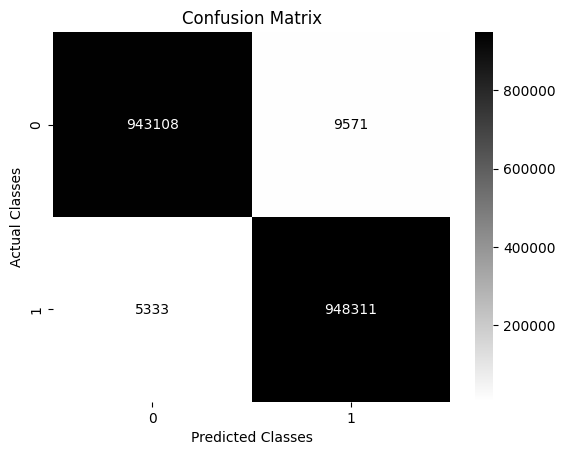

In [ ]:
# Confusion Matrix
cm=pycm.ConfusionMatrix(test_labels, test_predictions)
cm.plot(plot_lib="seaborn", number_label=True)


In [ ]:
# Calculating Recall (True positive rate, (TP/TP+FN))
print(cm.TPR,cm.ACC)

{0: 0.9899535940227506, 1: 0.9944077664201736} {0: 0.9921818075950403, 1: 0.9921818075950403}


The above confusion matrix suggests the following:
1. Model with SMOTE oversampling has a recall of 0.9944 and thus, it is much more accurate in finding Fraud cases.
2. Without oversampling with SMOTE, Out of 1221 fraud cases in test set, 900 were correctly classified as Fraud (True Positive) and 321 were classified as regular transactions (False Negatives). So the recall was 0.737. (See earlier version of notebook).
3. In a financial setting, usually the cost of a False Negative (a fraud transaction not detected) is higher than cost of a False Positive (a regular transaction tagged as fraud). Thus, this model is preferable to the model with less recall albeit there's going to be some inconvenience to customers when their legitimate transactions are classified as fraud.
4. Use of SMOTE oversampling method has drastically improved recall by reducing the class imbalance in this dataset.



#Model 2: XGBoost

Reference: https://github.com/PacktPublishing/Hands-On-Gradient-Boosting-with-XGBoost-and-Scikit-learn

In [26]:
!cd '/content/drive/MyDrive/Projects/Finance Dataset Kaggle'

In [27]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split

## Fitting initial classifier model with GPU options and default parameters

In [28]:
xgb = XGBClassifier(booster='gbtree', learning_rate=0.1, random_state=2, n_jobs=-1, tree_method='gpu_hist',predictor='gpu_predictor')
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
score = accuracy_score(y_pred, y_test)
print('Score: ' + str(score))

Score: 0.9955248926860768


In [29]:
confusion_matrix(y_test, y_pred)

array([[946066,   6613],
       [  1918, 951726]])

#### XGBoost performs better right out of the box with only 1918 False Negatives as opposed to 5333 in neural network

## Performing Hyperparameter tuning to improve recall.

In [39]:
# Import GridSearchCV
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

In [31]:
def grid_search(params, random=False):

    xgb = XGBClassifier(booster='gbtree', objective='binary:logistic', random_state=2,n_jobs=-1, tree_method='gpu_hist',predictor='gpu_predictor')

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

    if random:
        grid = RandomizedSearchCV(xgb, params, cv=kfold, n_iter=20, n_jobs=-1, random_state=2)
    else:
        # Instantiate GridSearchCV as grid_reg
        grid = GridSearchCV(xgb, params, cv=kfold, n_jobs=-1)

    grid.fit(X_train, y_train)

    best_params = grid.best_params_

    print("Best parameters:", best_params)

    best_score = grid.best_score_

    print("Best score: {:.5f}".format(best_score))

    y_pred = grid.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

    print(confusion_matrix(y_test, y_pred))

In [32]:
grid_search(params={'n_estimators':[800,1000,1200]})

Best params: {'n_estimators': 1200}
Best score: 0.99952
Accuracy: 99.96%
[[951905    774]
 [    40 953604]]


In [33]:
grid_search(params={'learning_rate':[0.01, 0.05, 0.5]})

Best params: {'learning_rate': 0.5}
Best score: 0.99803
Accuracy: 99.90%
[[951231   1448]
 [   429 953215]]


In [34]:
grid_search(params={'max_depth':[2, 10, 15]})

Best params: {'max_depth': 15}
Best score: 0.99946
Accuracy: 99.95%
[[951793    886]
 [    29 953615]]


In [35]:
grid_search(params={'gamma':[0.01, 0.1, 1]})

Best params: {'gamma': 0.01}
Best score: 0.99840
Accuracy: 99.84%
[[950451   2228]
 [   914 952730]]


In [36]:
grid_search(params={'min_child_weight':[1, 3, 5]})

Best params: {'min_child_weight': 3}
Best score: 0.99839
Accuracy: 99.83%
[[950401   2278]
 [   929 952715]]


In [37]:
grid_search(params={'subsample':[0.5, 0.9]})

Best params: {'subsample': 0.5}
Best score: 0.99839
Accuracy: 99.84%
[[950553   2126]
 [   843 952801]]


In [38]:
grid_search(params={'colsample_bytree':[0.5, 1]})

Best params: {'colsample_bytree': 1}
Best score: 0.99839
Accuracy: 99.84%
[[950468   2211]
 [   873 952771]]


Using the above parameters to fit final model

In [40]:
xgb = XGBClassifier(booster='gbtree', learning_rate=0.5, random_state=2, n_jobs=-1,\
                    n_estimators=1200, max_depth=15, min_child_weight=3, gamma=0.01,\
                    colsample_bytree=1, subsample=0.5,\
                    tree_method='gpu_hist',predictor='gpu_predictor')
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
score = accuracy_score(y_pred, y_test)
print('Score: ' + str(score))

Score: 0.9995703771081815


## Hyperparameter tuning

In [41]:
confusion_matrix(y_test, y_pred)

array([[951882,    797],
       [    22, 953622]])

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

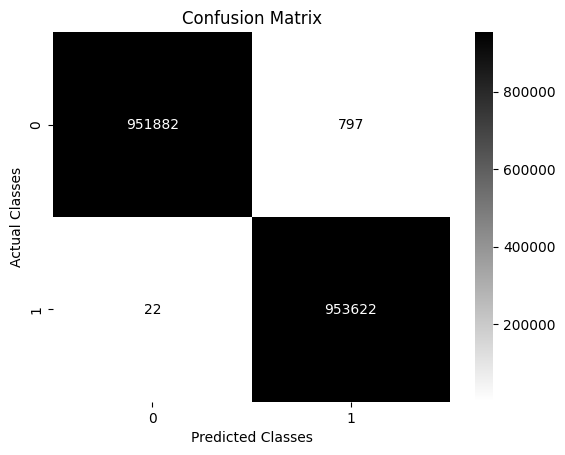

In [43]:
# Confusion Matrix
cm=pycm.ConfusionMatrix(list(y_test), list(y_pred))
cm.plot(plot_lib="seaborn", number_label=True)


In [44]:
print(cm.TPR, cm.ACC)

{'0': 0.999163411810274, '1': 0.9999769305946454} {'0': 0.9995703771081815, '1': 0.9995703771081815}


## Observations and Comparison with Neural Network model

The above confusion matrix suggests the following:
1. The recall of 0.999976 with XGBoost is echelons better than 0.9944 obtained with neural network.
2. Along with the far better performance, the XGBoost model is much easier to implement with less lines of code and far faster performance. The faster fitting also allows hyperparameter tuning with far less computational load.
4. This establishes the reputation of XGBoost as the best model available for tabular datasets. Neural networks are the best at dealing with unstructured or semi-structured data like images and text corpora.

